In [1]:
import imageio as io
import matplotlib.pyplot as plt
import numpy as np
import os
import tqdm
import torch

from PIL import Image
from pose_approximator import PoseApproximator

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Used device: {DEVICE}")

/home/filip/.conda/envs/state_approx/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Used device: cuda


<class 'numpy.ndarray'>
(966, 644, 3)


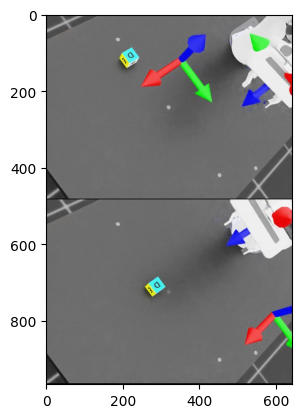

In [2]:
root = "../data/"
img_path = "../data/img.jpg"
img_pil = Image.open(img_path)
img = np.asarray(img_pil)
print(type(img))
print(img.shape)
plt.imshow(img)

query_img_paths = [
    os.path.join(root, "query_img1.jpg"),
    os.path.join(root, "query_img2.jpg"),
    os.path.join(root, "query_img3.jpg"),
]

query_imgs_pil = [ Image.open(img_path) for img_path in query_img_paths ]
query_imgs = [ np.asarray(img) for img in query_imgs_pil ]

/home/filip/.conda/envs/state_approx/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/filip/.conda/envs/state_approx/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed dur

[[283.68042 711.89374]
 [216.90256 114.51009]]
[[283.68042  711.89374   60.910233  60.294643]
 [216.90256  114.51009   55.122906  62.0154  ]]
(2, 4)


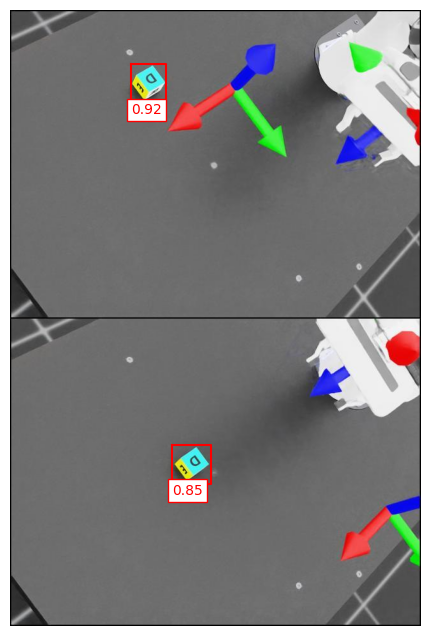

In [3]:
SAM_CHECKPOINT = "../segmentation/sam_checkpoint/sam_vit_h_4b8939.pth"

pose_approx = PoseApproximator(device=DEVICE, segm_checkpoint=SAM_CHECKPOINT)
od_tuple, segm_tuple = pose_approx(image=img_pil, query_image=query_imgs[0])

od_scores = od_tuple[0]
od_lbls = od_tuple[1]
od_boxes = od_tuple[2]

print(od_boxes)
print(od_boxes.shape)

segm_scores = segm_tuple[0] 
segm_masks = segm_tuple[1]
segm_coords = segm_tuple[2]
segm_lbls = segm_tuple[3]

pose_approx.plot_boxes(img=img, scores=od_scores, boxes=od_boxes)

scores:  (1,)
masks:  (1, 966, 644)


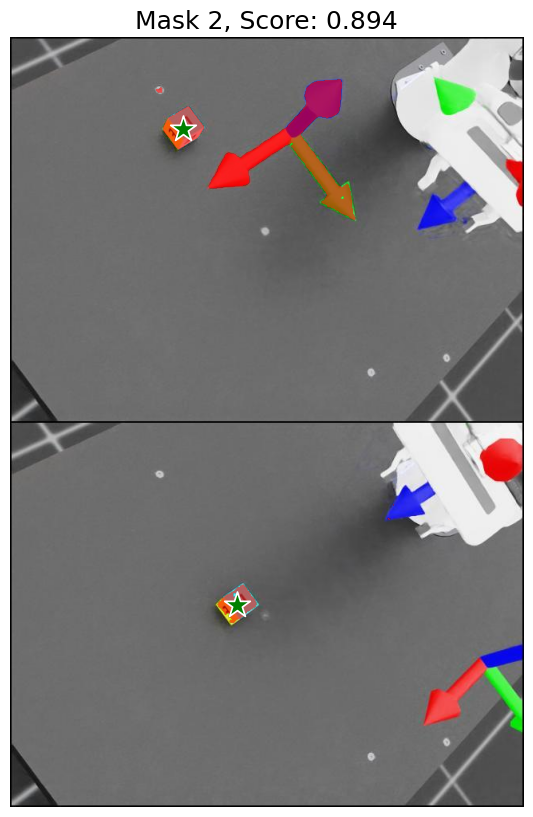

In [4]:
# TODO: Fix this as it shows the bg
print('scores: ', segm_scores.shape)
print('masks: ', segm_masks.shape)
pose_approx.plot_masks(img=np.asarray(img_pil), scores=segm_scores, masks=segm_masks, input_coords=segm_coords, input_lbls=segm_lbls)